<a href="https://www.kaggle.com/code/nurulsakinah/predicting-used-car-prices-eda-cleaning?scriptVersionId=198493186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction 
The goal is to predict the price of used cars based on various attributes

# 2. Import the libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
import matplotlib.pyplot as plt
# ignore warning on infin
import warnings
warnings.simplefilter('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# 3. Load the dataset


In [2]:
# read file
df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

# 4. Exploratory Data Analysis

In [3]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
def aggregate_info(df):
    ''' Calculate 
    count of unique, 
    unique values, 
    count & % of missing values, 
    data types of the columns '''
    nunique = df.nunique()
    unique = df.apply(lambda x: x.unique())
    missing_count = df.isna().sum()
    missing_percentage = round((df.isna().sum() / len(df)) * 100,2)
    dtypes = df.dtypes

    # combine metrics into a single DataFrame
    agg_df = pd.DataFrame({
        'nunique values': nunique,
        'unique': unique,
        'missing_count': missing_count,
        'missing_percentage': missing_percentage,
        'dtypes': dtypes
    })

    return agg_df

aggregate_info(df)

,nunique values,unique,missing_count,missing_percentage,dtypes
id,188533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.00,int64
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
model_year,34,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",0,0.00,int64
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,7,"[Gasoline, E85 Flex Fuel, nan, Hybrid, Diesel,...",5083,2.70,object
engine,1117,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",0,0.00,object
transmission,52,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",0,0.00,object
ext_col,319,"[Yellow, Silver, Blue, Black, White, Snowflake...",0,0.00,object
int_col,156,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",0,0.00,object


For fuel type, we can probably fill this missing values based on the engine type. <br>
From the engine feature alone, we can extract other details about the car. <br>
We will create ne features: 'engine_hp','engine_liter','engine_cyl','engine_fuel' in Feature Engineering

In [5]:
# Summary of Numeric Features 

def numeric_summary(df):
    obs = df.shape[0]
    
    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes, 
        'Counts': numeric_df.apply(lambda x: x.count()), 
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()), 
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Mean' : numeric_df.mean(),
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')
    })
    
    return summary_df


numeric_summary(df)

,Dtype,Counts,Nulls,NullPercent,Mean,Min,Max,Uniques,UniqueValues
id,int64,188533,0,0.0,94266.000000,0,188532,188533,-
model_year,int64,188533,0,0.0,2015.829998,1974,2024,34,-
milage,int64,188533,0,0.0,65705.295174,100,405000,6651,-
price,int64,188533,0,0.0,43878.016178,2000,2954083,1569,-


Lets plot to see more details on each features

In [6]:
# get the categorical variables
categorical_col = df.select_dtypes(include='object').columns.tolist()
print(categorical_col)
# get continous variable
cont_col = df.select_dtypes(include=['int']).columns.tolist()
# print(cont_col)
# drop 'id'
cont_col.remove('id') 
print(cont_col)

['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
['model_year', 'milage', 'price']


## Data Visualisation
### Univariate Analysis
We will start by plotting the continuous features to see their distributions.

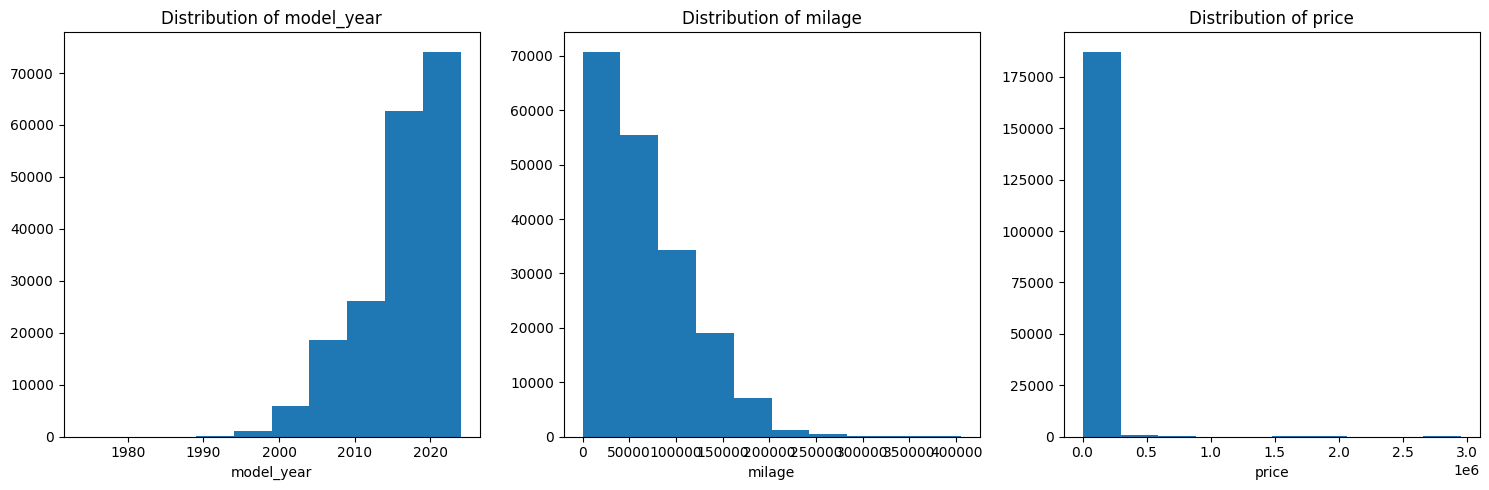

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns 

# plot histograms
for i, col in enumerate(cont_col):
    axs[i].hist(df[col])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

Univariate analysis for each categorical features

We can visually detect outliers using boxplots. From the boxplots, here are outliers in each of the continuous features, some deeper analysis would be needed before we handle these outliers

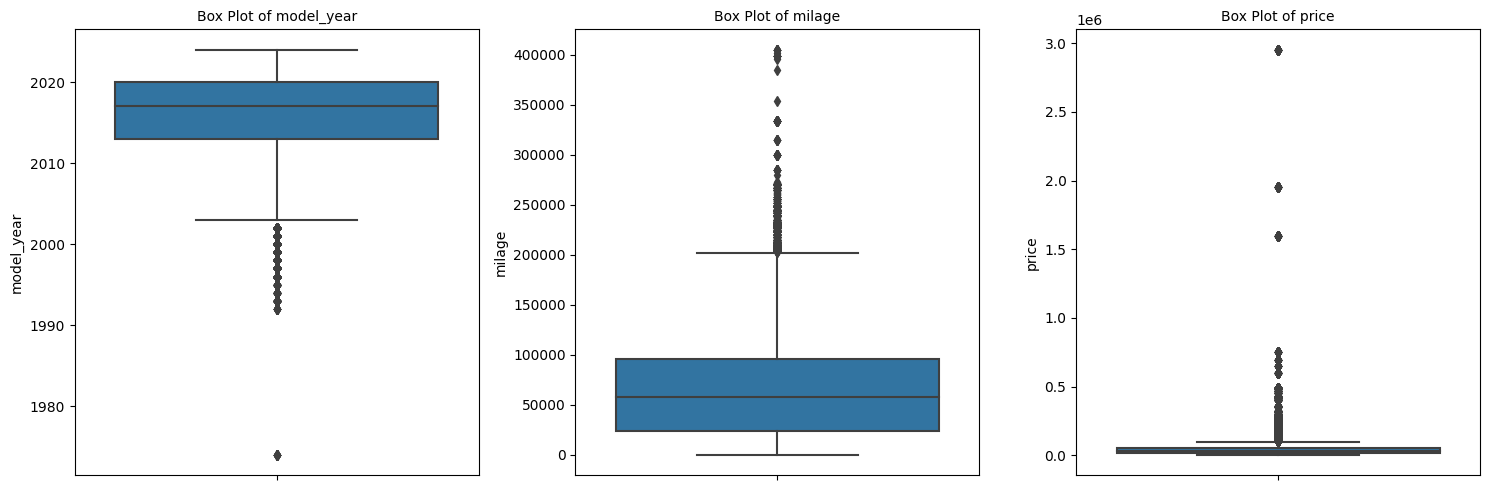

In [8]:
# lets do boxplot to identify outliers
# Creating grid of subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax = ax.flatten()
# Loop through columns and plot box plots
for idx, col in enumerate(cont_col):
    sns.boxplot(data=df, y=col, ax=ax[idx])
    ax[idx].set_title(f'Box Plot of {col}', fontsize=10)
    ax[idx].set_ylabel(col)

# Hide the empty subplot
if len(cont_col) < len(ax):
    ax[len(cont_col)].set_visible(False)
    
# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

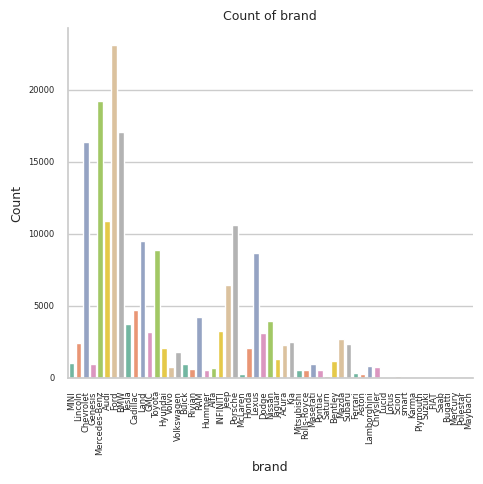

<Figure size 1200x600 with 0 Axes>

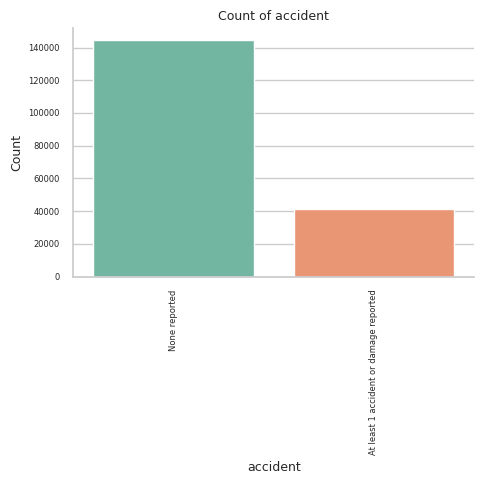

<Figure size 1200x600 with 0 Axes>

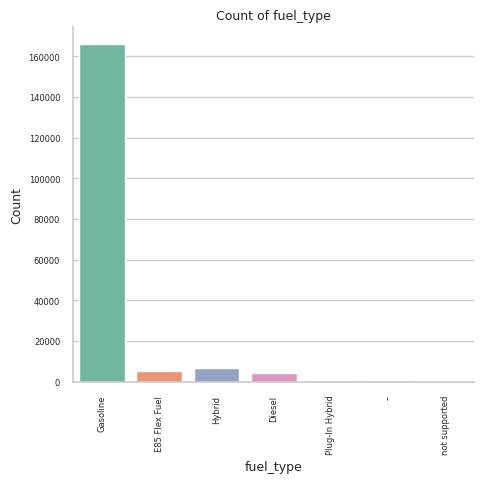

In [9]:
# check the occurences of each brand in 'brand' feature
# df['fuel_type'].value_counts()
#df[df['fuel_type'] == '–']

for i in ['brand', 'accident', 'fuel_type']:
    # set Seaborn theme 
    sns.set_theme(style="whitegrid")

    # create the plot with custom colors
    plt.figure(figsize=(12, 6))  
    sns.catplot(x= i, data=df, kind='count', palette='Set2')
    plt.title(f'Count of {i}', fontsize=9)
    plt.xlabel(f'{i}', fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6, rotation=90)
    sns.despine()
    plt.tight_layout()
    plt.show()

Gasoline has the highest count of fuel type, and there are also '-' and 'not supported' variables in the fuel_type feature.

### Multivariate Analysis

In [10]:
def plot_facetgrid(hue, x_axis):
    '''density plot and differentiate with another feature '''
    fig = sns.FacetGrid(df,hue=hue,aspect=3)
    fig.map(sns.kdeplot, x_axis, fill=True)
    oldest = df[x_axis].max()
    fig.set(xlim=(0,oldest))
    fig.add_legend()
    fig.fig.suptitle(f'Distribution of {x_axis} by {hue}')
# x_axis numerical, hue categorical

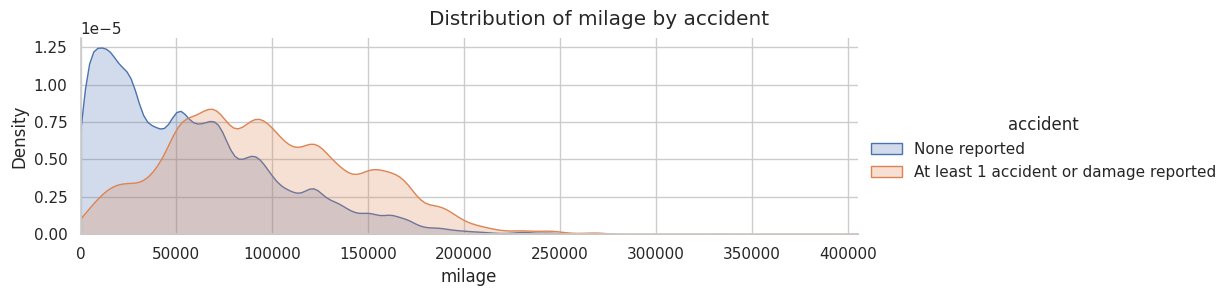

In [11]:
plot_facetgrid('accident', 'milage')

Lower mileage is associated with no accidents reported, while higher mileage has higher density of least one accident or damage reported.

In [12]:
def plot_scatter(feature_x, feature_y):
# for i in ['model_year', 'milage']:
    plt.figure(figsize=(6, 3))
    sns.scatterplot(data=df, x=feature_x, y=feature_y, s =20)
    # Set title and axis labels
    plt.title(f'{feature_x} vs {feature_y}', fontsize=9)
    plt.xlabel(f'{feature_x}', fontsize=8)
    plt.ylabel(f'{feature_y}', fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

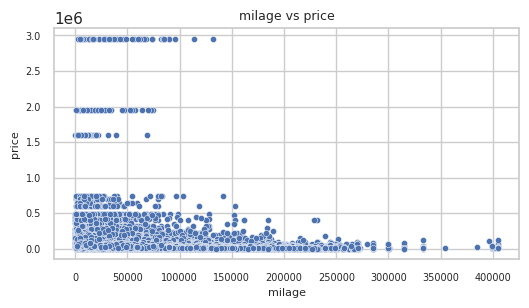

In [13]:
# plot milage
plot_scatter('milage', 'price')

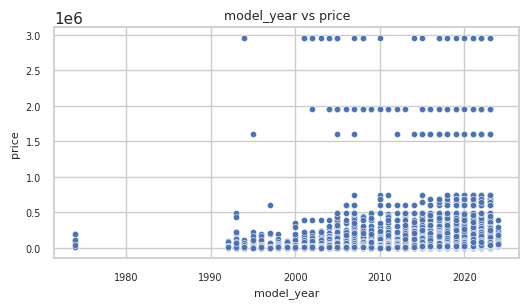

In [14]:
plot_scatter('model_year', 'price')

We dont really see any linear relationship between price & milage, price & model_year

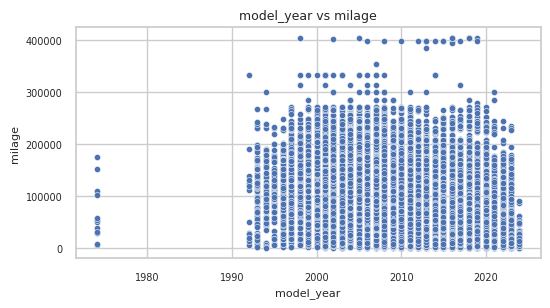

In [15]:
plot_scatter('model_year', 'milage')

Similarly, no linear relationship between model_year and milage

# 5. Feature Engineering

## Handling missing values

we will fill in the na values with 'missing' and let the model decides what to do, this works with gradient boosting DT model as they can handle missing values. However, there are some information that we can extract from engine feature and we can use that to impute into the missing values in fuel_type feature.

## Feature extraction from 'engine'
We will create new features by extracting information from the 'engine' feature. <br>
But first lets impute the missing values with the extracted words from engine. Let's see the unique values in engine where the fuel_type is na.

In [16]:
df[df['fuel_type'].isna()]['engine'].unique()

array(['Electric Motor Electric Fuel System',
       '518.0HP Electric Motor Electric Fuel System',
       'Dual Motor - Standard',
       '670.0HP Electric Motor Electric Fuel System', 'Electric',
       '455.0HP Electric Motor Electric Fuel System',
       '557.0HP Electric Motor Electric Fuel System',
       '200.0HP Electric Motor Electric Fuel System',
       '425.0HP Electric Motor Electric Fuel System',
       '214.0HP Electric Motor Electric Fuel System',
       '778.0HP Electric Motor Electric Fuel System',
       '835.0HP Electric Motor Electric Fuel System',
       '482.0HP Electric Motor Electric Fuel System',
       '480.0HP Electric Motor Electric Fuel System',
       '362.0HP Electric Motor Electric Fuel System',
       '201.0HP Electric Motor Electric Fuel System',
       '563.0HP Electric Motor Electric Fuel System',
       '271.0HP Electric Motor Electric Fuel System',
       '534.0HP Electric Motor Electric Fuel System',
       '266.0HP Electric Motor Electric Fuel S

In [17]:
# see the unique values in fuel_type
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [18]:
# change the '–' into missing values then we will impute it with whatever values extracted from engine
df['fuel_type'] = df['fuel_type'].replace('–', np.nan)
df['fuel_type'] = df['fuel_type'].replace('not supported', np.nan)

In [19]:
def extract_engine(s: str):
    
    # Extract fuel type
    fuel_types = ['Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Flex Fuel']
    fuel_ext = next((fuel for fuel in fuel_types if fuel in s), np.nan)  # Return the first matching fuel type, or an empty string

    s = s.lower()  # Convert to lowercase for uniformity
    
    # Extract horsepower
    hpgroup = re.search(r'(\d+(\.\d+)?)\s*hp', s)
    engine_hp = float(hpgroup.group(1)) if hpgroup else np.nan
    
    # Extract liters (L or Liter)
    litergroup = re.search(r'(\d+(\.\d+)?)\s*[Ll](?:iter)?', s)
    engine_liter = float(litergroup.group(1)) if litergroup else np.nan
    
    # Extract cylinder count
    cylindergroup = re.search(r'(\d+)\s*cylinders?|([ivxlcdm]+)\s*cylinders?', s)
    if cylindergroup:
        engine_cyl = int(cylindergroup.group(1)) if cylindergroup.group(1) else cylindergroup.group(2).upper()
    else:
        engine_cyl = ''
    
    
    return engine_hp, engine_liter, engine_cyl, fuel_ext
 

df[['engine_hp','engine_liter','engine_cyl','engine_fuel']]=df['engine'].apply(extract_engine).apply(pd.Series)

There are some input in engine where there is only '3.0L' information available. 
So we can retrieve the fuel type from the extracted fuel from the engine if the row fuel is missing, but do not delete the original fuel_type column. <br>

In [20]:
df.head(3)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,engine_fuel
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4,Gasoline
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8,Gasoline
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8,Flex Fuel


In [21]:
# replace the missing values in fuel_type column with the extracted fuel from engine 'engine_fuel'
df['fuel_type'] = df['fuel_type'].fillna(df['engine_fuel'])

# check again for sanity
aggregate_info(df)

#df[df['fuel_type'].isna()]['engine'].unique()

,nunique values,unique,missing_count,missing_percentage,dtypes
id,188533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.00,int64
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
model_year,34,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",0,0.00,int64
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,7,"[Gasoline, E85 Flex Fuel, Electric, Hybrid, Di...",951,0.50,object
engine,1117,"[172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,...",0,0.00,object
transmission,52,"[A/T, Transmission w/Dual Shift Mode, 7-Speed ...",0,0.00,object
ext_col,319,"[Yellow, Silver, Blue, Black, White, Snowflake...",0,0.00,object
int_col,156,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",0,0.00,object


Seems like we had managed to reduce the number of missing values in fuel_type to 0.50% only.

In [22]:
# see the unique values in fuel_type
df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electric', 'Hybrid', 'Diesel', nan,
       'Plug-In Hybrid', 'Flex Fuel'], dtype=object)

After creating new features, it is better to convert the 'E85 Flex Fuel' to 'Flex Fuel' in the fuel_type feature. 

In [23]:
df['fuel_type'] = df['fuel_type'].replace('E85 Flex Fuel', 'Flex Fuel')
df.fuel_type.unique()

array(['Gasoline', 'Flex Fuel', 'Electric', 'Hybrid', 'Diesel', nan,
       'Plug-In Hybrid'], dtype=object)

## Feature extration from 'Transmission'

From this feature, we can extract the types of transmission and types of gear

In [24]:
df.transmission.value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [25]:
def extract_transmission(s:str):    
    # extract speed
    speedgroup = re.search(r'(\d+)', s)
    speed = int(speedgroup.group(1)) if speedgroup else np.nan
    
    # extract manual, automatic or other
    s = s.lower()
    
    # search for automatic
    if re.search(r'(automatic | at | a/t)', s):
        gear = 'Automatic'
    elif re.search(r'(manual | mt | m/t)', s):
        gear = 'Manual'
    elif re.search(r'(dual|at/mt)', s):
        gear = 'Dual'
    else:
        gear = 'other'
    
    return speed, gear

# a = '8-SPEED 10 A/T'
# test, test_gear = extract_transmission(a)
# print(test)
# print(test_gear)

# apply the function
df[['speed', 'gear']] = df['transmission'].apply(extract_transmission).apply(pd.Series)

In [26]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,engine_fuel,speed,gear
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4,Gasoline,NaN,other
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8,Gasoline,NaN,other
2,2,Chevrolet,Silverado 2500 LT,2002,136731,Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8,Flex Fuel,NaN,other
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8,Gasoline,NaN,Dual
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4,Gasoline,7.0,Automatic


## Cleaning
we going to remove the feature 'id', 'engine', 'transmission' as they could be redundant and become noise for the model. For feature 'accident' and 'clean_title', we will let it remain na as it is. We're not sure why it is missing, and othe other hand since there is only one values in the features, imputing them with that values would make these feature not useful as the model will not be able to learn anything from it.

In [27]:
# replace nan values to 'missing'
# df['clean_title'] = df['clean_title'].fillna('missing')
# df['accident'] = df['accident'].fillna('missing')

# drop features
df = df.drop(columns=['engine', 'transmission', 'engine_fuel'])
df.head(5)

,id,brand,model,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_hp,engine_liter,engine_cyl,speed,gear
0,0,MINI,Cooper S Base,2007,213000,Gasoline,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4,NaN,other
1,1,Lincoln,LS V8,2002,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8,NaN,other
2,2,Chevrolet,Silverado 2500 LT,2002,136731,Flex Fuel,Blue,Gray,None reported,Yes,13900,320.0,5.3,8,NaN,other
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Black,Black,None reported,Yes,45000,420.0,5.0,8,NaN,Dual
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,Black,Beige,None reported,Yes,97500,208.0,2.0,4,7.0,Automatic


In [28]:
# check again for sanity
aggregate_info(df)

,nunique values,unique,missing_count,missing_percentage,dtypes
id,188533,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,0.00,int64
brand,57,"[MINI, Lincoln, Chevrolet, Genesis, Mercedes-B...",0,0.00,object
model,1897,"[Cooper S Base, LS V8, Silverado 2500 LT, G90 ...",0,0.00,object
model_year,34,"[2007, 2002, 2017, 2021, 2018, 2016, 2020, 201...",0,0.00,int64
milage,6651,"[213000, 143250, 136731, 19500, 7388, 40950, 6...",0,0.00,int64
fuel_type,6,"[Gasoline, Flex Fuel, Electric, Hybrid, Diesel...",951,0.50,object
ext_col,319,"[Yellow, Silver, Blue, Black, White, Snowflake...",0,0.00,object
int_col,156,"[Gray, Beige, Black, –, Blue, White, Red, Brow...",0,0.00,object
accident,2,"[None reported, At least 1 accident or damage ...",2452,1.30,object
clean_title,1,"[Yes, nan]",21419,11.36,object


### Handling outliers
For now we are just going to remove the outliers in the feature milage. 
Sometime the outliers represent actual, meaningful data points (for example luxury cars with very high prices), they shouldn't be removed, as these represent important variations in the data.

In [29]:
def handling_outliers(feature):
    ''' calculate percent of outliers and remove them'''
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df_outliers = df[(df[feature] <= lower) | (df[feature] >= upper)]
    
    percent_outlier = round(len(df_outliers)/len(df)*100,4)
    print(df_outliers[feature].value_counts())
    print('Percentage of outliers:',percent_outlier)
    df_cleaned = df[(df[feature] >= lower) & (df[feature] <= upper)]
    return df_cleaned
    

df_cleaned = handling_outliers('milage')

milage
245000    99
215000    86
244000    66
207100    66
239000    61
          ..
248421     1
253300     1
272400     1
232500     1
263620     1
Name: count, Length: 119, dtype: int64
Percentage of outliers: 0.9367


# 6. Building the Model 